In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [40]:
recs_codebook_df = pd.read_excel('recs2020_codebook.xlsx', header=1)
recs_data = pd.read_csv('recs2020_data.csv')

# Remove columns that are output from other models
cols_to_remove = recs_codebook_df[recs_codebook_df['Section'] == 'End-use Model'].Variable.unique().tolist()
more_cols_to_keep = [col for col in recs_data.columns if col not in cols_to_remove]

# Subset the dataframe to remove unnecessary columns
big_subset_df = recs_data[more_cols_to_keep]

We handle missing values in the numerical and categorical columns separately. For numerical columns, we impute missing values using the median. For categorical columns, we impute missing values with the most frequent category.

In [41]:
imputer = SimpleImputer(strategy='median')
num_df = big_subset_df.select_dtypes(include=['number'])
num_df_imputed = pd.DataFrame(imputer.fit_transform(num_df), columns=num_df.columns)

categorical_df = big_subset_df.select_dtypes(exclude=['number'])
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_df_imputed = pd.DataFrame(cat_imputer.fit_transform(categorical_df), columns=categorical_df.columns)

In this step, we normalize the numerical features using MinMaxScaler and one-hot encode the categorical variables to prepare the data for PCA and clustering.

In [42]:
# Normalize numeric columns using MinMaxScaler
scaler = MinMaxScaler()
normalized_num_df = pd.DataFrame(scaler.fit_transform(num_df_imputed), columns=num_df_imputed.columns)

# One-hot encode the categorical columns
one_hot_encoded_df = pd.get_dummies(categorical_df_imputed)

# Combine the numeric and categorical dataframes
final_df = pd.concat([normalized_num_df, one_hot_encoded_df], axis=1)

final_df.head()

,DOEID,STATE_FIPS,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,TYPEHUQ,CELLAR,CRAWL,CONCRETE,...,IECC_climate_code_5B,IECC_climate_code_6A,IECC_climate_code_6B,IECC_climate_code_7A,IECC_climate_code_7AK,IECC_climate_code_7B,IECC_climate_code_8AK,UATYP10_C,UATYP10_R,UATYP10_U
0,0.000000,0.618182,0.221136,0.303397,0.276958,0.209378,0.25,0.666667,0.666667,1.000000,...,False,False,False,False,False,False,False,False,False,True
1,0.000054,0.072727,0.216648,0.263462,0.275590,0.266055,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
2,0.000108,0.618182,0.219697,0.306469,0.280007,0.205912,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
3,0.000162,0.800000,0.150377,0.310445,0.200921,0.337003,0.25,0.666667,1.000000,0.666667,...,False,False,False,False,False,False,False,False,False,True
4,0.000216,0.600000,0.242708,0.246296,0.304648,0.215902,1.00,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True


We apply PCA to reduce the dimensionality of the dataset and analyze how much variance each principal component explains. This step helps us determine the number of components needed to capture 90-95% of the variance.

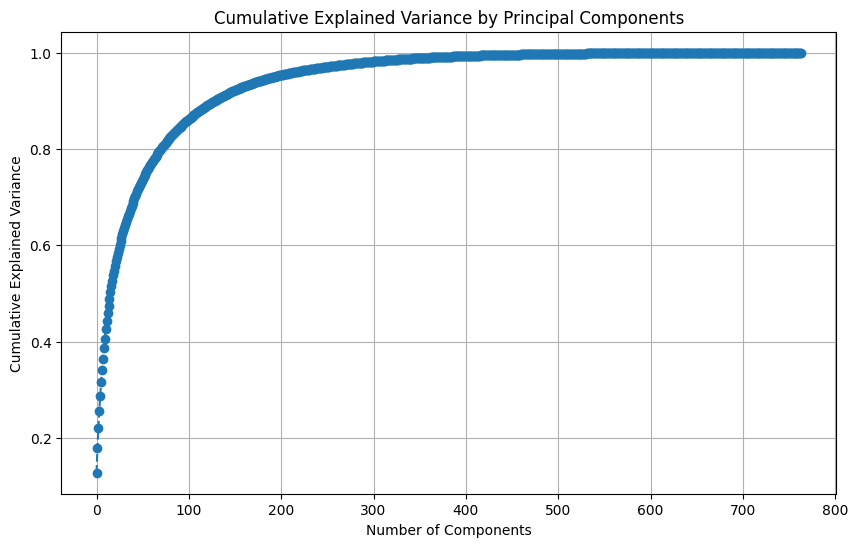

In [43]:
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(final_df)

# Calculate the cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [44]:
# Find the number of components that explain at least 90% of the variance
explained_variance_90 = np.where(explained_variance >= 0.90)[0][0] + 1  # +1 to get the actual component count
explained_variance_95 = np.where(explained_variance >= 0.95)[0][0] + 1  # +1 to get the actual component count

print(f"Number of components explaining 90% variance: {explained_variance_90}")
print(f"Number of components explaining 95% variance: {explained_variance_95}")


Number of components explaining 90% variance: 129
Number of components explaining 95% variance: 194


Based on the PCA results, we reduce the dataset to 129 components (90% variance explained) and perform K-means clustering to find the optimal number of clusters using the Elbow Method.

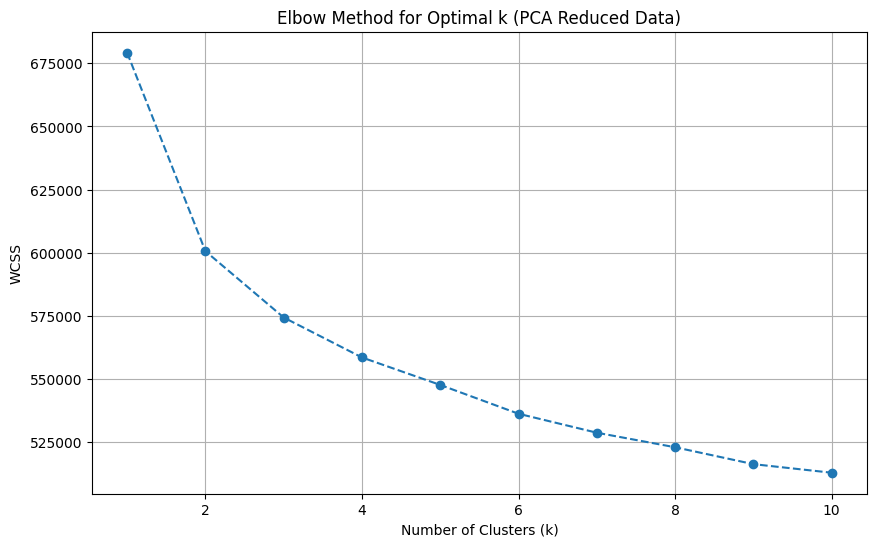

In [45]:
# Reduce the data to 129 components (for 90% variance)
pca_90 = PCA(n_components=129)
pca_90_result = pca_90.fit_transform(final_df)

# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Using the Elbow Method, we choose k=3k=3 and visualize the K-means clusters by reducing the PCA data to 2 components for plotting.

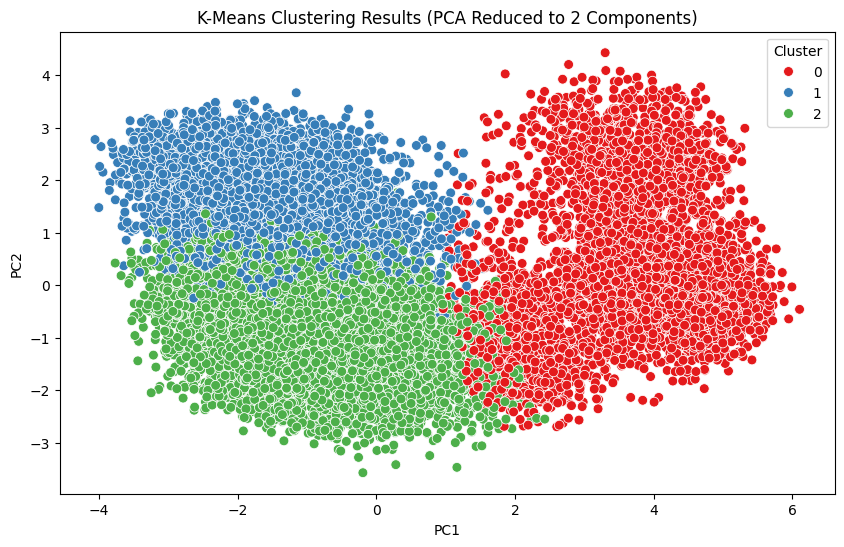

In [46]:
# Perform K-means clustering with the chosen k (3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We plot a dendrogram to visualize the hierarchical structure of the clusters and cut the dendrogram at a threshold to identify clusters.

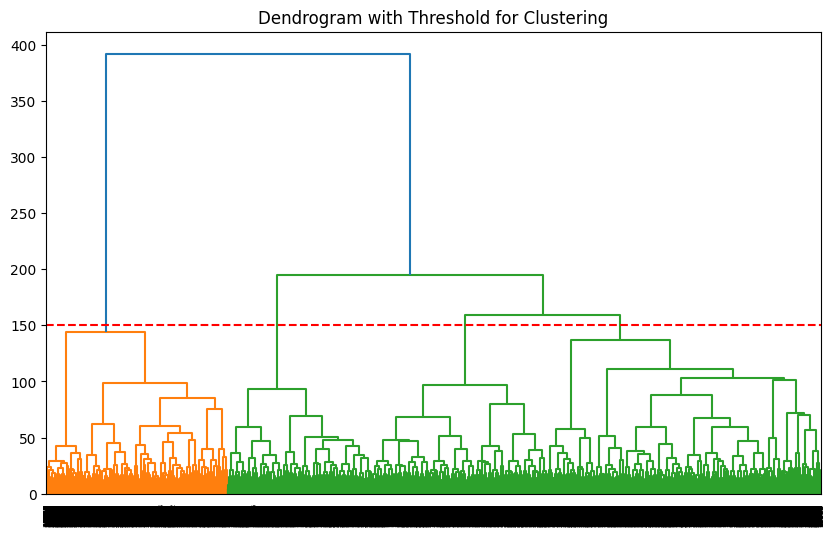

In [47]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.axhline(y=150, color='r', linestyle='--')  # Adjust the y-value to focus on higher levels of clustering
plt.show()


After determining the number of clusters from the dendrogram, we perform hierarchical clustering and visualize the results using the first two PCA components.

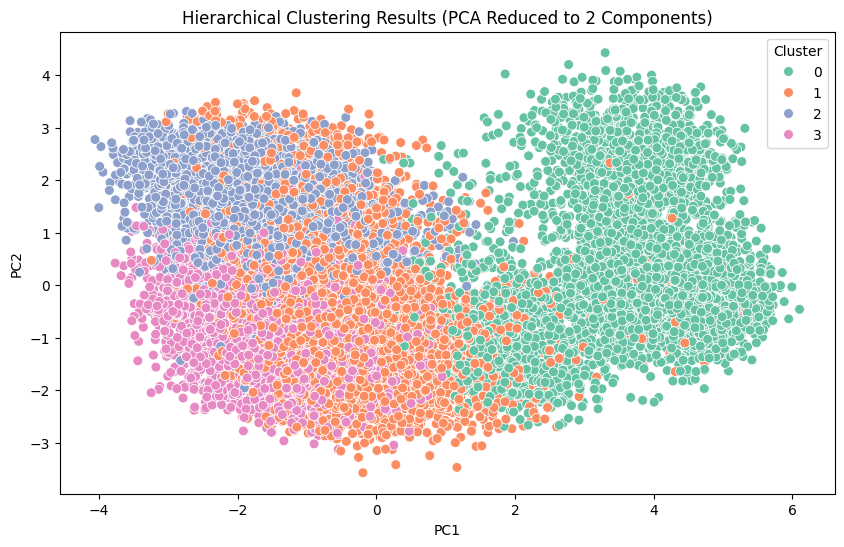

In [49]:
# Perform Hierarchical Clustering with 4 clusters
hierarchical = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  # Use 129-component PCA data

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [51]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(big_subset_df.copy(), kmeans_labels)
print(kmeans_summary)

# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(big_subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

                 DOEID                           STATE_FIPS                 \
                  mean    median     min     max       mean median min max   
Cluster                                                                      
0        109095.323583  109033.5  100002  118494  28.238803   29.0   1  56   
1        109421.330764  109520.0  100006  118492  28.210967   27.0   1  56   
2        109236.544211  109233.0  100001  118496  28.706128   29.0   1  56   

               HDD65          ... EVCHRGOTH      EVHOMEAMT                   \
                mean  median  ...       min  max      mean median  min  max   
Cluster                       ...                                             
0        4043.245201  4207.0  ...      -2.0  1.0 -1.990629   -2.0 -2.0  6.0   
1        4280.327020  4462.0  ...      -2.0  1.0 -1.885853   -2.0 -2.0  6.0   
2        4372.181752  4488.0  ...      -2.0  1.0 -1.962917   -2.0 -2.0  6.0   

        EVCHRGTYPE                   
              mean

In [53]:
# Generate mode (most frequent category) for categorical columns
def get_categorical_summary(data, cluster_labels):
    # Add the Cluster labels to the data
    data['Cluster'] = cluster_labels
    # Select only categorical columns along with the Cluster column
    categorical_data = data.select_dtypes(include=['object', 'category']).copy()
    categorical_data['Cluster'] = data['Cluster']  # Ensure Cluster column is included
    
    # Group by Cluster and calculate the mode (most frequent category) for each column
    summary = categorical_data.groupby('Cluster').agg(lambda x: x.mode().iloc[0])
    return summary

# Apply to K-means clusters
kmeans_categorical_summary = get_categorical_summary(big_subset_df.copy(), kmeans_labels)
print(kmeans_categorical_summary)

# Apply to hierarchical clusters
hierarchical_categorical_summary = get_categorical_summary(big_subset_df.copy(), hierarchical_labels)
print(hierarchical_categorical_summary)

        REGIONC        DIVISION state_postal  state_name BA_climate  \
Cluster                                                               
0         SOUTH  South Atlantic           NY    New York       Cold   
1         SOUTH  South Atlantic           CA  California       Cold   
2         SOUTH  South Atlantic           TX       Texas       Cold   

        IECC_climate_code UATYP10  
Cluster                            
0                      4A       U  
1                      4A       U  
2                      5A       U  
         REGIONC            DIVISION state_postal    state_name   BA_climate  \
Cluster                                                                        
0          SOUTH      South Atlantic           NY      New York         Cold   
1          SOUTH             Pacific           CA    California  Mixed-Humid   
2          SOUTH      South Atlantic           TX         Texas         Cold   
3        MIDWEST  West North Central           PA  Pennsylvania 